# AnoGAN_2018.12.21_SJH


--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size   =  100
workers       =  4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
image_size    =  64
channel       =  1
num_epochs    =  100
batch_size    =  64
learning_rate =  1e-5

#fms          =  64   # feature_map_size
#sample_dir   =  'samples'
#num_epochs   =  200
#batch_size   =  100

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#dataroot = "./dataset"
dataroot = "./image/new_steel_2/train"
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MODEL

In [4]:
# Generative Adversarial Networks Model

class Generator(nn.Module):
    # nn.convTranspose2d(input,output,kernl,stride,padding,bias)
    
    def __init__(self):
        super(Generator,self).__init__()
        self.G_layer1 = nn.Sequential(    
            
            # ----------------input is latent_size 100--------------------
            nn.ConvTranspose2d(latent_size,512,4,1,0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        
            # -----------------state size 512x4x4-------------------------
            nn.ConvTranspose2d(512, 256 , 4, 2, 1, bias=False ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            # -----------------state size 256x8x8--------------------------
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # -----------------state size 128x16x16-------------------------
            nn.ConvTranspose2d(128, 64 , 4, 2, 1, bias=False ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # ------------------state size 64x32x32--------------------------
            nn.ConvTranspose2d(64, 1 , 4, 2, 1, bias=False ),
            nn.Tanh()
            
            # state size 1x64x64
        )
    
    def forward(self, input):
        out = self.G_layer1(input)
        return out

class Discriminator(nn.Module):
    # nn.conv2d(input,output,kernl,stride,padding,bias)
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # ===================== Feature 추출 layer ====================
        self.D_feature = nn.Sequential(
            # -------------input is 1 x 64 x 64----------------------
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # -------------state size 64x32x32-----------------------
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # --------------state size 128x16x16---------------------
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # --------------state size 256x8x8------------------------
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        # =================== Binary classification 1 or 0 layer ==========
        self.D_final=nn.Sequential(
            
            # ---------------state size 512x4x4-------------------------
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        out = self.D_feature(input)
        #out = out.view(out.size()[0], -1)
        feature = out
        out = self.D_final(out)
        
        return out,feature
        

# Loss & Optim

In [5]:
# G and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# D,G 네트워크 모델 객체 선언
D = Discriminator().to(device)
G = Generator().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
G.apply(weights_init)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 G로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(64, latent_size, 1, 1, device = device)

# D와 G에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(G)

def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

# Train

In [6]:


img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(dataloader,0):
        
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        # =============================================================
        #                       Train Discriminator
        # =============================================================
        image       =  data[0].to(device)  # image size: 64x1x64x64(batch, channel, width, height)
        b_size      =  image.size(0)       # b_size = 64
        real_labels =  torch.ones(b_size, 1).to(device)
        fake_labels =  torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        output,_   =  D(image) # output = D(x)
        loss_real  =  criterion(output, real_labels) # D(x)=1일 때의 loss
        real_score =  output
        D_x        =  real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z          =  torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_image =  G(z)
        output,_   =  D(fake_image) # output = D(G(z))
        loss_fake  =  criterion(output, fake_labels) # D(G(z))=0일 때의 loss
        fake_score =  output
        D_G_z1     =  fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        loss_D     =  loss_real + loss_fake 
        reset_grad()
        loss_D.backward()
        D_optimizer.step() # D(x)=1, D(G(z))=0이어야 D가 최적
        
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        
        # =============================================================
        #                       Train Generater
        # =============================================================
        #z          = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(4):
            fake_image = G(z)
            output,_   = D(fake_image)  # output : D(G(z))
            D_G_z2     = output.mean().item()
            loss_G     = criterion(output, real_labels) # D(G(z))=1일 때의 loss=log(D(G(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            loss_G.backward()
            G_optimizer.step() # D(G(z))=1 이어야 G가 최적

            # ==> D(G(z))의 값이 0.5로 수렴해야 한다.
        
        # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
        
        
        # ---------------------------------------------------------------------------------
        #                                               print
        # ---------------------------------------------------------------------------------
        if i%50 == 0:
            print('[%d/%d][%d/%d]\n- Loss_D: %.4f / Loss_G:%.4f\n- D(x):%.4f / D(G(z1)):%.4f / D(G(z2)):%.4f' 
                  %(epoch+1, num_epochs, i, len(dataloader),loss_D.item(),
                    loss_G.item(),D_x,D_G_z1,D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(G.state_dict(), 'G.ckpt')
#torch.save(D.state_dict(), 'D.ckpt')

/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[1/100][0/15]
- Loss_D: 1.3966 / Loss_G:0.6908
- D(x):0.4940 / D(G(z1)):0.4991 / D(G(z2)):0.5012
[2/100][0/15]
- Loss_D: 1.3375 / Loss_G:0.6646
- D(x):0.5387 / D(G(z1)):0.5127 / D(G(z2)):0.5145
[3/100][0/15]
- Loss_D: 1.2909 / Loss_G:0.6491
- D(x):0.5749 / D(G(z1)):0.5216 / D(G(z2)):0.5225
[4/100][0/15]
- Loss_D: 1.2572 / Loss_G:0.6425
- D(x):0.5994 / D(G(z1)):0.5254 / D(G(z2)):0.5260
[5/100][0/15]
- Loss_D: 1.2350 / Loss_G:0.6386
- D(x):0.6159 / D(G(z1)):0.5277 / D(G(z2)):0.5280
[6/100][0/15]
- Loss_D: 1.2145 / Loss_G:0.6374
- D(x):0.6305 / D(G(z1)):0.5291 / D(G(z2)):0.5287
[7/100][0/15]
- Loss_D: 1.1754 / Loss_G:0.6518
- D(x):0.6455 / D(G(z1)):0.5218 / D(G(z2)):0.5211
[8/100][0/15]
- Loss_D: 1.1555 / Loss_G:0.6617
- D(x):0.6523 / D(G(z1)):0.5172 / D(G(z2)):0.5160
[9/100][0/15]
- Loss_D: 1.1183 / Loss_G:0.6838
- D(x):0.6618 / D(G(z1)):0.5061 / D(G(z2)):0.5047
[10/100][0/15]
- Loss_D: 1.0799 / Loss_G:0.7085
- D(x):0.6718 / D(G(z1)):0.4944 / D(G(z2)):0.4924
[11/100][0/15]
- Loss_D: 1.03

[85/100][0/15]
- Loss_D: 1.3910 / Loss_G:0.6901
- D(x):0.4991 / D(G(z1)):0.5015 / D(G(z2)):0.5015
[86/100][0/15]
- Loss_D: 1.3914 / Loss_G:0.6899
- D(x):0.4990 / D(G(z1)):0.5015 / D(G(z2)):0.5016
[87/100][0/15]
- Loss_D: 1.3926 / Loss_G:0.6884
- D(x):0.4990 / D(G(z1)):0.5022 / D(G(z2)):0.5024
[88/100][0/15]
- Loss_D: 1.3921 / Loss_G:0.6888
- D(x):0.4993 / D(G(z1)):0.5022 / D(G(z2)):0.5022
[89/100][0/15]
- Loss_D: 1.3913 / Loss_G:0.6901
- D(x):0.4990 / D(G(z1)):0.5015 / D(G(z2)):0.5015
[90/100][0/15]
- Loss_D: 1.3898 / Loss_G:0.6905
- D(x):0.4995 / D(G(z1)):0.5013 / D(G(z2)):0.5013
[91/100][0/15]
- Loss_D: 1.3898 / Loss_G:0.6902
- D(x):0.4996 / D(G(z1)):0.5014 / D(G(z2)):0.5015
[92/100][0/15]
- Loss_D: 1.3908 / Loss_G:0.6889
- D(x):0.4999 / D(G(z1)):0.5021 / D(G(z2)):0.5021
[93/100][0/15]
- Loss_D: 1.3909 / Loss_G:0.6881
- D(x):0.5002 / D(G(z1)):0.5024 / D(G(z2)):0.5026
[94/100][0/15]
- Loss_D: 1.3904 / Loss_G:0.6905
- D(x):0.4992 / D(G(z1)):0.5012 / D(G(z2)):0.5013
[95/100][0/15]
- Los

# Graph

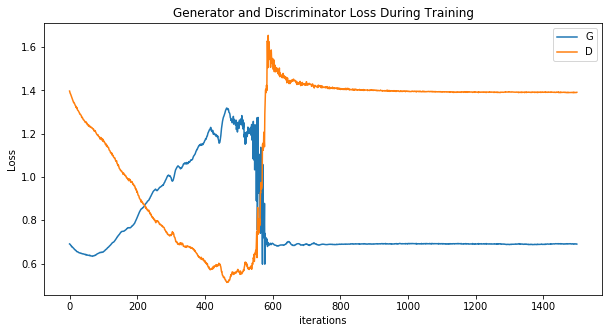

In [7]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Animation

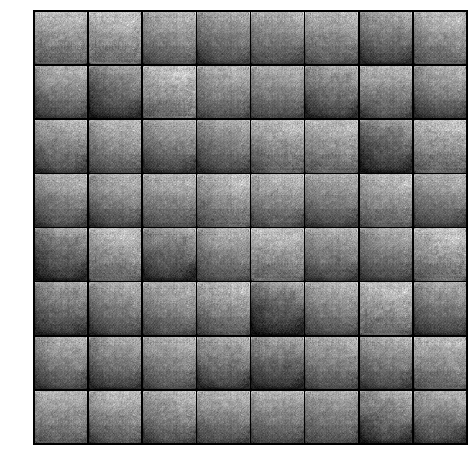

In [8]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

# Anomaly Loss

In [9]:
latent_vector = torch.randn(1, latent_size, 1, 1, device = device, requires_grad=True)
def Anomaly_loss(Test_Data, G_Data, Lambda=0.1):
    
    _, Test_Data_feature =  D(Test_Data)
    _, G_Data_feature    =  D(G_Data)
    loss_residual        =  torch.sum(torch.abs(Test_Data - G_Data))
    loss_discrimination  =  torch.sum(torch.abs(Test_Data_feature - G_Data_feature))
    loss_ano             =  (1-Lambda)*loss_residual + Lambda*loss_discrimination
    
    return loss_ano

z_optimizer = torch.optim.Adam([latent_vector],lr=0.01,betas=(0.5, 0.999))

test_dataroot = "./image/new_steel_2/test"
test_dataset = dset.ImageFolder(root = test_dataroot,
                           transform = transforms.Compose([
                                  transforms.Resize(image_size),
                                  transforms.CenterCrop(image_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 1,
                                         shuffle = False, num_workers = workers)

# Train Latent Space Z

In [10]:
latent_space = []
auc=[]
for i,data in enumerate(test_dataloader,0):
    test_image = data[0].to(device)
    print("picture ",i)
    for step in range(1001):

        G_Data   = G(latent_vector)
        loss_ano = Anomaly_loss(test_image, G_Data)

        z_optimizer.zero_grad()

        # residual loss, dicriminator loss 의 그래디언트를 학습 가능한 weight에 독립적으로 반역하기 위해서
        # 한쪽 로스를 업데이트하면 그래디언트가 해제되서 
        loss_ano.backward(retain_graph = True)
        
        z_optimizer.step()

        if step%200 == 0:

            loss   = loss_ano.item()
            noises = torch.sum(latent_vector).item()
            print("[%d]\t loss_Ano:%.4f  Sum_of_z:%.4f" %(step,loss,noises))
            if step==1000:
                latent_space.append(latent_vector.cpu().data.numpy())
                if loss>500:
                    auc.append(1)
                else :
                    auc.append(0)
latent_space = np.array(latent_space)
latent_space = torch.Tensor(latent_space).to(device)

picture  0
[0]	 loss_Ano:122.7998  Sum_of_z:22.1708
[200]	 loss_Ano:105.5689  Sum_of_z:9.0011
[400]	 loss_Ano:103.5888  Sum_of_z:9.2801
[600]	 loss_Ano:103.0360  Sum_of_z:9.4765
[800]	 loss_Ano:102.8409  Sum_of_z:10.9930
[1000]	 loss_Ano:102.8195  Sum_of_z:11.4749
picture  1
[0]	 loss_Ano:106.4402  Sum_of_z:10.9817
[200]	 loss_Ano:71.3105  Sum_of_z:7.6211
[400]	 loss_Ano:70.6688  Sum_of_z:8.2915
[600]	 loss_Ano:70.5408  Sum_of_z:8.0030
[800]	 loss_Ano:70.5217  Sum_of_z:7.8207
[1000]	 loss_Ano:70.4143  Sum_of_z:7.9094
picture  2
[0]	 loss_Ano:225.5673  Sum_of_z:7.7854
[200]	 loss_Ano:203.1146  Sum_of_z:-5.8517
[400]	 loss_Ano:202.1335  Sum_of_z:-6.0618
[600]	 loss_Ano:201.9359  Sum_of_z:-6.4627
[800]	 loss_Ano:201.8692  Sum_of_z:-6.0545
[1000]	 loss_Ano:201.7738  Sum_of_z:-7.0314
picture  3
[0]	 loss_Ano:149.3529  Sum_of_z:-7.9297
[200]	 loss_Ano:72.2691  Sum_of_z:-5.6426
[400]	 loss_Ano:71.4999  Sum_of_z:-5.8047
[600]	 loss_Ano:71.2109  Sum_of_z:-6.0844
[800]	 loss_Ano:71.0623  Sum_of_

# Similar Z , Ano_Score and Segementation


/home/pirl/anaconda3/envs/pytorch/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


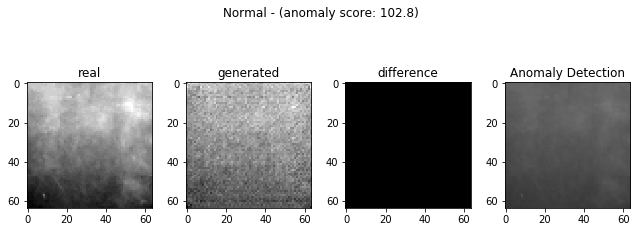

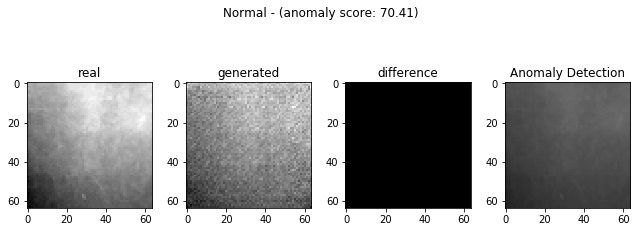

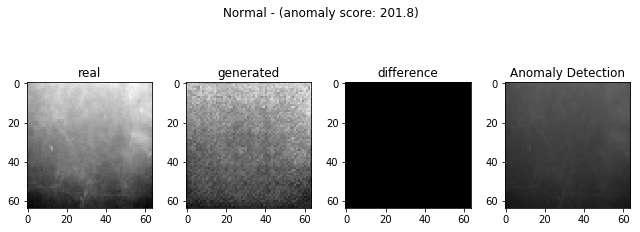

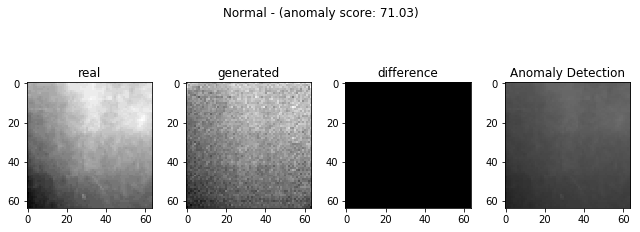

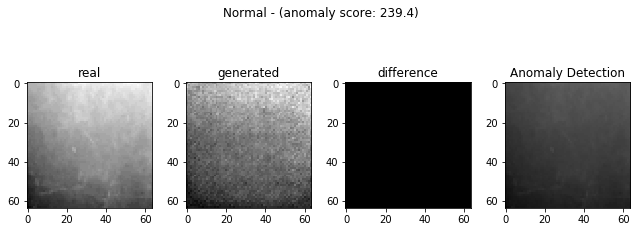

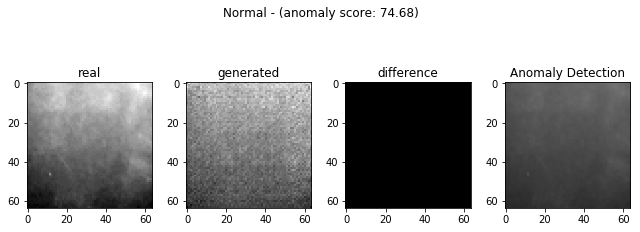

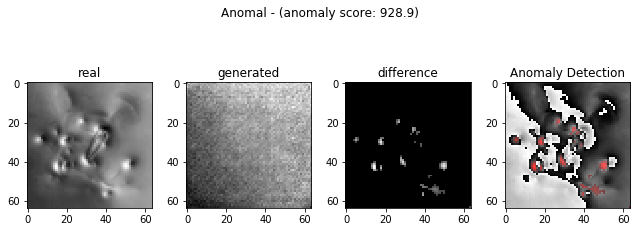

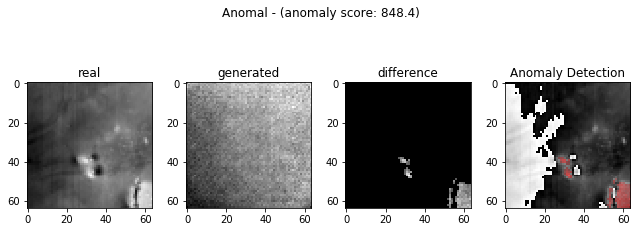

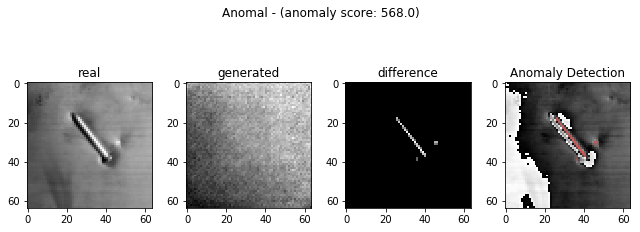

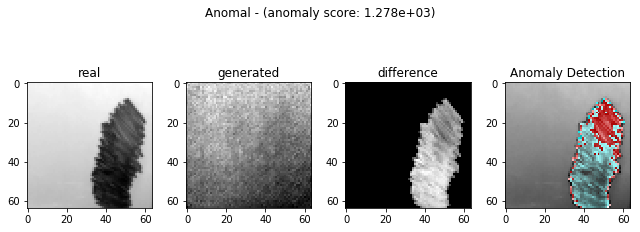

In [11]:
def compare_images(real_img, generated_img,i, reverse=False, threshold=50):
    score = Anomaly_loss(real_img, generated_img)
    score = round(score.item(), 2)
    
    real_img = real_img.cpu().data.numpy().reshape(64, 64) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(64, 64) * 255
    
    #generated_img = generated_img.astype(np.uint8)
    
    negative = np.zeros_like(real_img)
    
    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img
    diff_img[diff_img <= threshold] = 0
    
    anomaly_img = np.zeros(shape=(64, 64, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)
    
    fig, plots = plt.subplots(1, 4)
    if auc[i]==0:
        fig.suptitle(f'Normal - (anomaly score: {score:.4})')
    else :
        fig.suptitle(f'Anomal - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label='real')
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')

vali_label=[0,0,0,0,0,1,1,1,1,1,1]
for i,data in enumerate(test_dataloader,0):
    test_image = data[0].to(device)

    #for i in range(len(latent_space)):
    update_z =  latent_space[i]
    R_img    =  test_image
    G_img    =  G(update_z).to(device)
    if i in [9]:
        compare_images(R_img, G_img,i,reverse = True, threshold = 50)
    else:
        compare_images(R_img, G_img,i,reverse = False, threshold = 50)